# Rapid Intensification (RI) Prediction — Atlantic Hurricanes (HURDAT2)

**Goal:** Build a machine learning classifier that predicts whether a tropical cyclone will **rapidly intensify** within the next 24 hours, using only information available *up to the current observation time*.

**Definition (label):**
Rapid Intensification (RI) = **maximum sustained wind increases by ≥ 30 knots within 24 hours**.

**Dataset:** Kaggle — Atlantic Hurricane Dataset (HURDAT2), cleaned CSV format (`hurdat2.csv`).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, classification_report
)

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_PATH = Path("hurdat2.csv")


In [2]:
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (54749, 24)


,storm_id,storm_name,num_of_obs,date,time,record_identifier,status_of_system,latitude,longitude,maximum_sustained_wind_knots,...,34_kt_nw_nm,50_kt_ne_nm,50_kt_se_nm,50_kt_sw_nm,50_kt_nw_nm,64_kt_ne_nm,64_kt_se_nm,64_kt_sw_nm,64_kt_nw_nm,radius_of_max_wind_nm
0,AL011851,UNNAMED,14,18510625,0,NaN,HU,28.0N,94.8W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,14,18510625,600,NaN,HU,28.0N,95.4W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,14,18510625,1200,NaN,HU,28.0N,96.0W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,14,18510625,1800,NaN,HU,28.1N,96.5W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,14,18510625,2100,L,HU,28.2N,96.8W,80,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


## Dataset Overview

This dataset contains storm track observations (typically 6-hour intervals).
Each row is an observation for a storm at a timestamp, including:

- **Storm metadata:** `storm_id`, `storm_name`
- **Time:** `date`, `time`
- **Location:** `latitude`, `longitude`
- **Intensity:** `maximum_sustained_wind_knots` (target driver), and often pressure-related fields if present
- **Storm status:** `status_of_system` (e.g., TS, HU)

We will:
1. Clean and parse timestamps.
2. Convert latitude/longitude strings to numeric.
3. Create an RI label from wind change over the next 24 hours.
4. Train multiple ML models using proper storm-wise splits.

In [3]:
df.info()

missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_pct.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54749 entries, 0 to 54748
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   storm_id                      54749 non-null  object
 1   storm_name                    54749 non-null  object
 2   num_of_obs                    54749 non-null  int64 
 3   date                          54749 non-null  int64 
 4   time                          54749 non-null  int64 
 5   record_identifier             1221 non-null   object
 6   status_of_system              54749 non-null  object
 7   latitude                      54749 non-null  object
 8   longitude                     54749 non-null  object
 9   maximum_sustained_wind_knots  54749 non-null  int64 
 10  central_pressure_mb           54749 non-null  int64 
 11  34_kt_ne_nm                   54749 non-null  int64 
 12  34_kt_se_nm                   54749 non-null  int64 
 13  34_kt_sw_nm     

record_identifier               97.769822
storm_id                         0.000000
34_kt_sw_nm                      0.000000
64_kt_nw_nm                      0.000000
64_kt_sw_nm                      0.000000
64_kt_se_nm                      0.000000
64_kt_ne_nm                      0.000000
50_kt_nw_nm                      0.000000
50_kt_sw_nm                      0.000000
50_kt_se_nm                      0.000000
50_kt_ne_nm                      0.000000
34_kt_nw_nm                      0.000000
34_kt_se_nm                      0.000000
storm_name                       0.000000
34_kt_ne_nm                      0.000000
central_pressure_mb              0.000000
maximum_sustained_wind_knots     0.000000
longitude                        0.000000
latitude                         0.000000
status_of_system                 0.000000
dtype: float64

In [4]:
def parse_lat(lat):
    # often like "18.0N" or "18.0"
    if pd.isna(lat):
        return np.nan
    s = str(lat).strip()
    if s[-1] in ["N", "S"]:
        val = float(s[:-1])
        return val if s[-1] == "N" else -val
    return float(s)

def parse_lon(lon):
    # often like "65.0W" or "65.0"
    if pd.isna(lon):
        return np.nan
    s = str(lon).strip()
    if s[-1] in ["E", "W"]:
        val = float(s[:-1])
        return val if s[-1] == "E" else -val
    return float(s)

# timestamp: date as YYYYMMDD and time as HHMM (or sometimes integer like 0, 600, 1200, 1800)
df["date"] = df["date"].astype(str)
df["time"] = df["time"].astype(str).str.zfill(4)

df["timestamp"] = pd.to_datetime(df["date"] + df["time"], format="%Y%m%d%H%M", errors="coerce", utc=True)

df["lat"] = df["latitude"].apply(parse_lat)
df["lon"] = df["longitude"].apply(parse_lon)

WIND_COL = "maximum_sustained_wind_knots"
df[WIND_COL] = pd.to_numeric(df[WIND_COL], errors="coerce").replace(-99, np.nan)

print(df[["storm_id","storm_name","timestamp","lat","lon",WIND_COL]].head())
print("Timestamp null %:", df["timestamp"].isna().mean()*100)

   storm_id storm_name                 timestamp   lat   lon  \
0  AL011851    UNNAMED 1851-06-25 00:00:00+00:00  28.0 -94.8   
1  AL011851    UNNAMED 1851-06-25 06:00:00+00:00  28.0 -95.4   
2  AL011851    UNNAMED 1851-06-25 12:00:00+00:00  28.0 -96.0   
3  AL011851    UNNAMED 1851-06-25 18:00:00+00:00  28.1 -96.5   
4  AL011851    UNNAMED 1851-06-25 21:00:00+00:00  28.2 -96.8   

   maximum_sustained_wind_knots  
0                          80.0  
1                          80.0  
2                          80.0  
3                          80.0  
4                          80.0  
Timestamp null %: 0.0


## Exploratory Data Analysis (EDA)

We will look at:
- distribution of wind speed
- storm status breakdown
- geographic scatter plot
- time coverage

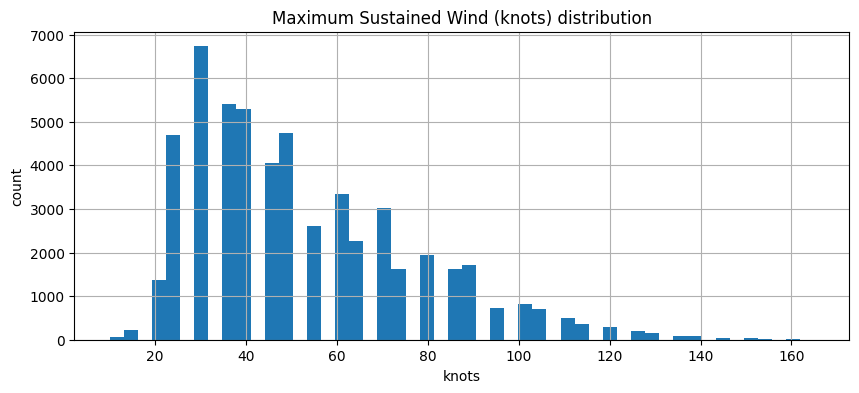

status_of_system
TS    20089
HU    15517
TD     9872
EX     6129
LO     1686
SS      715
SD      326
DB      277
WV      138
Name: count, dtype: int64

In [5]:
fig, ax = plt.subplots(figsize=(10,4))
df[WIND_COL].dropna().hist(bins=50, ax=ax)
ax.set_title("Maximum Sustained Wind (knots) distribution")
ax.set_xlabel("knots")
ax.set_ylabel("count")
plt.show()

df["status_of_system"].value_counts().head(15)

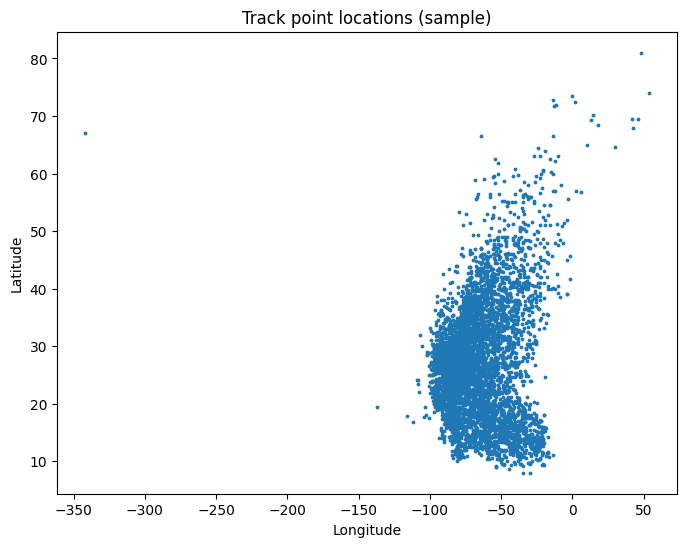

In [6]:
sample = df.dropna(subset=["lat","lon"]).sample(n=min(5000, len(df)), random_state=RANDOM_SEED)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(sample["lon"], sample["lat"], s=3)
ax.set_title("Track point locations (sample)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## Label Construction: Rapid Intensification (RI)

We create a binary label **RI_24h**:

- For each storm observation at time *t*, we find the wind at time *t + 24 hours* (or closest observation at that horizon).
- If `wind(t+24h) - wind(t) >= 30 knots`, then **RI_24h = 1**, else 0.

**Important:** Our features must use only data available at or before time *t* to avoid leakage.

In [7]:
df = df.sort_values(["storm_id", "timestamp"]).reset_index(drop=True)

# We'll approximate "24h ahead" using 4 steps of 6-hourly data.
# But because some storms have irregularities, we do a safer merge using shift by 4 within each storm.
# This is a common and reasonable approach for HURDAT2 6-hourly tracks.

df["wind_t"] = df[WIND_COL]
df["wind_t_plus_24h"] = df.groupby("storm_id")["wind_t"].shift(-4)  # 4*6h = 24h
df["delta_wind_24h"] = df["wind_t_plus_24h"] - df["wind_t"]

df["RI_24h"] = (df["delta_wind_24h"] >= 30).astype(int)

# Drop rows where label can't be computed (end of storm) or wind missing
model_df = df.dropna(subset=["wind_t","wind_t_plus_24h","timestamp","lat","lon"]).copy()

print("Model rows:", model_df.shape)
print("RI positive rate:", model_df["RI_24h"].mean())
model_df[["storm_id","timestamp","wind_t","wind_t_plus_24h","delta_wind_24h","RI_24h"]].head(10)

Model rows: (46894, 31)
RI positive rate: 0.036166673774896574


,storm_id,timestamp,wind_t,wind_t_plus_24h,delta_wind_24h,RI_24h
0,AL011851,1851-06-25 00:00:00+00:00,80.0,80.0,0.0,0
1,AL011851,1851-06-25 06:00:00+00:00,80.0,70.0,-10.0,0
2,AL011851,1851-06-25 12:00:00+00:00,80.0,60.0,-20.0,0
3,AL011851,1851-06-25 18:00:00+00:00,80.0,60.0,-20.0,0
4,AL011851,1851-06-25 21:00:00+00:00,80.0,50.0,-30.0,0
5,AL011851,1851-06-26 00:00:00+00:00,70.0,50.0,-20.0,0
6,AL011851,1851-06-26 06:00:00+00:00,60.0,40.0,-20.0,0
7,AL011851,1851-06-26 12:00:00+00:00,60.0,40.0,-20.0,0
8,AL011851,1851-06-26 18:00:00+00:00,50.0,40.0,-10.0,0
9,AL011851,1851-06-27 00:00:00+00:00,50.0,40.0,-10.0,0


## Feature Engineering

We will build features that mimic a real monitoring/forecasting setup:

**Current-state features**
- wind now, lat, lon, storm status

**Trend features (past-only)**
- wind change over last 6h, 12h, 24h (computed via lagged values within each storm)
- recent rolling mean

These are simple but strong baseline signals and align with the “textbook ML workflow” before adding deep learning.

In [11]:
feat_df = model_df.sort_values(["storm_id", "timestamp"]).copy()

g = feat_df.groupby("storm_id")

feat_df["wind_lag_1"] = g["wind_t"].shift(1)
feat_df["wind_lag_2"] = g["wind_t"].shift(2)
feat_df["wind_lag_4"] = g["wind_t"].shift(4)

feat_df["dwind_6h"] = feat_df["wind_t"] - feat_df["wind_lag_1"]
feat_df["dwind_12h"] = feat_df["wind_t"] - feat_df["wind_lag_2"]
feat_df["dwind_24h_past"] = feat_df["wind_t"] - feat_df["wind_lag_4"]

feat_df["wind_rollmean_4"] = g["wind_t"].rolling(4).mean().reset_index(level=0, drop=True)

feat_df = feat_df.dropna(subset=["wind_lag_1", "wind_lag_2", "wind_lag_4", "wind_rollmean_4"]).copy()

print("After lag features:", feat_df.shape)
feat_df[["storm_id","timestamp","wind_t","dwind_6h","dwind_12h","dwind_24h_past","wind_rollmean_4","RI_24h"]].head()

After lag features: (39332, 38)


,storm_id,timestamp,wind_t,dwind_6h,dwind_12h,dwind_24h_past,wind_rollmean_4,RI_24h
4,AL011851,1851-06-25 21:00:00+00:00,80.0,0.0,0.0,0.0,80.0,0
5,AL011851,1851-06-26 00:00:00+00:00,70.0,-10.0,-10.0,-10.0,77.5,0
6,AL011851,1851-06-26 06:00:00+00:00,60.0,-10.0,-20.0,-20.0,72.5,0
7,AL011851,1851-06-26 12:00:00+00:00,60.0,0.0,-10.0,-20.0,67.5,0
8,AL011851,1851-06-26 18:00:00+00:00,50.0,-10.0,-10.0,-30.0,60.0,0


## Train / Validation / Test Split (Storm-wise)

We must split by **storm_id** so that observations from the same storm do not leak across train/val/test.

We will do:
- Train: 70%
- Validation: 15%
- Test: 15%

This matches realistic generalization: predicting on **new storms**.

In [12]:
X = feat_df.copy()
y = feat_df["RI_24h"].astype(int).copy()
groups = feat_df["storm_id"].copy()

# First split: train vs temp
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=RANDOM_SEED)
train_idx, temp_idx = next(gss1.split(X, y, groups=groups))

train = feat_df.iloc[train_idx].copy()
temp  = feat_df.iloc[temp_idx].copy()

# Second split: val vs test from temp
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=RANDOM_SEED)
val_idx, test_idx = next(gss2.split(temp, temp["RI_24h"], groups=temp["storm_id"]))

val  = temp.iloc[val_idx].copy()
test = temp.iloc[test_idx].copy()

print("Train:", train.shape, "Val:", val.shape, "Test:", test.shape)
print("Train RI rate:", train["RI_24h"].mean())
print("Val   RI rate:", val["RI_24h"].mean())
print("Test  RI rate:", test["RI_24h"].mean())

Train: (26694, 38) Val: (6259, 38) Test: (6379, 38)
Train RI rate: 0.03154266876451637
Val   RI rate: 0.03866432337434095
Test  RI rate: 0.032293462925223386


## Modeling with Pipelines

We will use scikit-learn Pipelines to ensure clean, reproducible preprocessing:
- numeric: impute + scale
- categorical: impute + one-hot encode

Then we train multiple models:
- Perceptron
- Logistic Regression
- SVM (linear and RBF)
- KNN
- Decision Tree
- Random Forest

We select the best model based on validation metrics.
Because RI is imbalanced, we will track:
- Accuracy (easy to inflate)
- F1 (balance precision/recall)
- ROC-AUC
- PR-AUC (Average Precision) — best for imbalanced positives

In [13]:
target = "RI_24h"

feature_cols_num = [
    "wind_t", "lat", "lon",
    "wind_lag_1", "wind_lag_2", "wind_lag_4",
    "dwind_6h", "dwind_12h", "dwind_24h_past",
    "wind_rollmean_4"
]

feature_cols_cat = ["status_of_system"]

# Some datasets might have status missing; keep safe
for c in feature_cols_cat:
    if c not in feat_df.columns:
        feat_df[c] = np.nan
        train[c] = np.nan
        val[c] = np.nan
        test[c] = np.nan

X_train, y_train = train[feature_cols_num + feature_cols_cat], train[target]
X_val, y_val     = val[feature_cols_num + feature_cols_cat], val[target]
X_test, y_test   = test[feature_cols_num + feature_cols_cat], test[target]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)

In [14]:
def eval_model(name, model, Xtr, ytr, Xva, yva):
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    pipe.fit(Xtr, ytr)

    pred = pipe.predict(Xva)

    # probabilities/scores for AUC
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        proba = pipe.predict_proba(Xva)[:, 1]
    elif hasattr(pipe.named_steps["model"], "decision_function"):
        scores = pipe.decision_function(Xva)
        # convert scores to 0..1-ish via minmax for PR-AUC stability
        proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    else:
        proba = None

    acc = accuracy_score(yva, pred)
    prec = precision_score(yva, pred, zero_division=0)
    rec = recall_score(yva, pred, zero_division=0)
    f1 = f1_score(yva, pred, zero_division=0)

    roc = roc_auc_score(yva, proba) if proba is not None else np.nan
    pr  = average_precision_score(yva, proba) if proba is not None else np.nan

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr,
        "pipeline": pipe
    }

## Evaluation Note: Class Imbalance (Why Accuracy Can Mislead)

Rapid Intensification (RI_24h) is rare in this dataset (~3–4% positives).
That means a naive classifier that predicts **"no RI" for every case** can still achieve ~96–97% accuracy.

So we do **not** choose the best model by accuracy alone.

We track:
- **PR-AUC (Average Precision)**: best single metric when positives are rare (how well the model ranks true RI cases).
- **Recall**: how many RI events we successfully catch (sensitivity).
- **Precision**: how many predicted RI events are correct (false alarm control).
- **F1**: balance of precision and recall.
- **ROC-AUC**: ranking quality (can look optimistic under heavy imbalance).

**Model selection rule for this project:** prioritize **PR-AUC**, then check **Recall/F1** to ensure the model actually detects RI events.

In [15]:
models = [
    ("Perceptron", Perceptron(random_state=RANDOM_SEED)),
    ("LogReg", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_SEED)),
    ("LinearSVM", SVC(kernel="linear", class_weight="balanced", probability=True, random_state=RANDOM_SEED)),
    ("RBFSVM", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=RANDOM_SEED)),
    ("KNN", KNeighborsClassifier(n_neighbors=15)),
    ("DecisionTree", DecisionTreeClassifier(max_depth=6, random_state=RANDOM_SEED, class_weight="balanced")),
    ("RandomForest", RandomForestClassifier(
        n_estimators=300, random_state=RANDOM_SEED, class_weight="balanced", n_jobs=-1
    )),
]

results = []
for name, m in models:
    out = eval_model(name, m, X_train, y_train, X_val, y_val)
    results.append(out)

score_table = pd.DataFrame([{k:v for k,v in r.items() if k!="pipeline"} for r in results])
score_table.sort_values("pr_auc", ascending=False)

,model,accuracy,precision,recall,f1,roc_auc,pr_auc
2,LinearSVM,0.733823,0.108791,0.818182,0.192047,0.845293,0.166107
1,LogReg,0.720083,0.104712,0.826446,0.185874,0.845610,0.164983
5,DecisionTree,0.725835,0.105460,0.814050,0.186730,0.835339,0.144205
3,RBFSVM,0.728072,0.110043,0.851240,0.194891,0.837445,0.141177
6,RandomForest,0.958140,0.142857,0.016529,0.029630,0.798891,0.133476
4,KNN,0.961176,0.000000,0.000000,0.000000,0.738291,0.106664
0,Perceptron,0.751078,0.074386,0.475207,0.128635,0.711054,0.071031


## Interpreting the Validation Results

Some models show very high **accuracy** (e.g., KNN / RandomForest), but their **recall is near zero**.
This indicates the model is mostly predicting the majority class ("no RI"), which inflates accuracy but fails the real task: detecting intensification events.

We therefore focus on models with stronger **PR-AUC** and reasonable **Recall/F1**.
In this run, **LinearSVM and Logistic Regression** have the best PR-AUC, suggesting better ranking of RI candidates for downstream triage.

## Baseline: Always Predict "No RI"

As a sanity check, compare against a trivial baseline:

- Baseline prediction: RI_24h = 0 for all rows
- Expected accuracy ≈ (1 - positive_rate)

This baseline often looks "good" on accuracy, which is why PR-AUC / Recall / F1 are essential for rare-event detection.

## Model Selection

We choose the best model based primarily on **Validation PR-AUC**, with F1 as a secondary metric.
PR-AUC is ideal because RI is relatively rare (imbalanced classification).

Best model (by Val PR-AUC, then F1): LinearSVM


,model,accuracy,precision,recall,f1,roc_auc,pr_auc
2,LinearSVM,0.733823,0.108791,0.818182,0.192047,0.845293,0.166107
1,LogReg,0.720083,0.104712,0.826446,0.185874,0.845610,0.164983
5,DecisionTree,0.725835,0.105460,0.814050,0.186730,0.835339,0.144205
3,RBFSVM,0.728072,0.110043,0.851240,0.194891,0.837445,0.141177
6,RandomForest,0.958140,0.142857,0.016529,0.029630,0.798891,0.133476
4,KNN,0.961176,0.000000,0.000000,0.000000,0.738291,0.106664
0,Perceptron,0.751078,0.074386,0.475207,0.128635,0.711054,0.071031



TEST METRICS
Accuracy: 0.7220567487066938
Precision: 0.078082929456112
Recall: 0.7038834951456311
F1: 0.14057198254968492
ROC-AUC: 0.7782615807328817
PR-AUC : 0.11448488310002018

Confusion matrix:
 [[4461 1712]
 [  61  145]]

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83      6173
           1       0.08      0.70      0.14       206

    accuracy                           0.72      6379
   macro avg       0.53      0.71      0.49      6379
weighted avg       0.96      0.72      0.81      6379


Positive rate in TEST: 0.0323 (~3.23%)
Reminder: high accuracy can still mean the model predicts 'No RI' almost always.


status_of_system_HU    1.420517
status_of_system_WV   -1.331766
status_of_system_TS    0.846088
status_of_system_LO   -0.740711
lat                   -0.559322
dwind_6h               0.530963
status_of_system_DB   -0.415289
status_of_system_SD    0.310857
lon                   -0.285798
dwind_12h              0.214240
wind_lag_1            -0.210649
wind_lag_2            -0.174707
status_of_system_SS   -0.132854
wind_lag_4            -0.126465
status_of_system_EX    0.109272
wind_t                -0.097151
wind_rollmean_4        0.078082
status_of_system_TD   -0.066114
dwind_24h_past         0.052849
dtype: float64

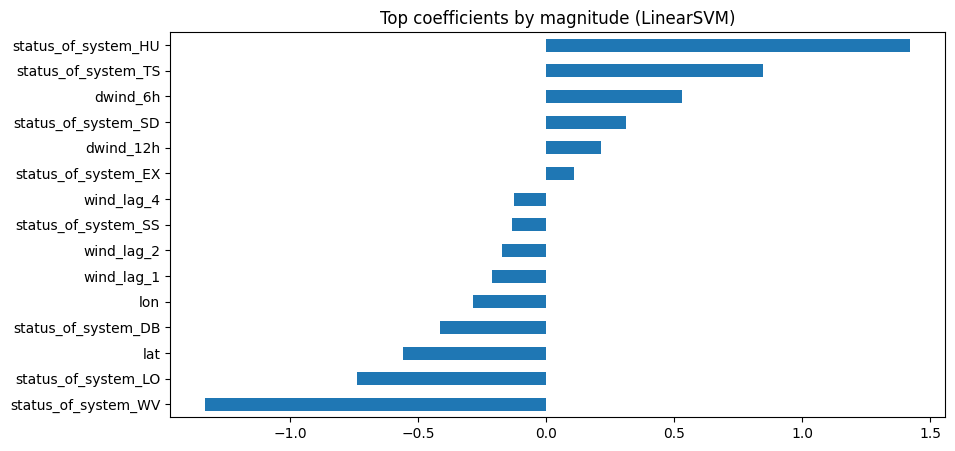

In [16]:
import numpy as np
import pandas as pd

# Model selection
def safe_score(x):
    """Treat NaN as very bad so sorting is stable."""
    return -np.inf if (x is None or (isinstance(x, float) and np.isnan(x))) else x

best = sorted(
    results,
    key=lambda r: (safe_score(r.get("pr_auc")), safe_score(r.get("f1"))),
    reverse=True
)[0]

best_name = best["model"]
best_pipe = best["pipeline"]

print("Best model (by Val PR-AUC, then F1):", best_name)
display(score_table.sort_values("pr_auc", ascending=False).head(10))

# Evaluate on TEST

test_pred = best_pipe.predict(X_test)

# probabilities/scores for AUC
if hasattr(best_pipe.named_steps["model"], "predict_proba"):
    test_scores = best_pipe.predict_proba(X_test)[:, 1]
elif hasattr(best_pipe.named_steps["model"], "decision_function"):
    test_scores = best_pipe.decision_function(X_test)
else:
    test_scores = None

print("\nTEST METRICS")
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Precision:", precision_score(y_test, test_pred, zero_division=0))
print("Recall:", recall_score(y_test, test_pred, zero_division=0))
print("F1:", f1_score(y_test, test_pred, zero_division=0))

if test_scores is not None:
    print("ROC-AUC:", roc_auc_score(y_test, test_scores))
    print("PR-AUC :", average_precision_score(y_test, test_scores))
else:
    print("ROC-AUC: N/A (no scores available)")
    print("PR-AUC : N/A (no scores available)")

print("\nConfusion matrix:\n", confusion_matrix(y_test, test_pred))
print("\nClassification report:\n", classification_report(y_test, test_pred, zero_division=0))


# Interpretation helper

pos_rate = y_test.mean()
print(f"\nPositive rate in TEST: {pos_rate:.4f} (~{pos_rate*100:.2f}%)")
print("Reminder: high accuracy can still mean the model predicts 'No RI' almost always.")


# Model explanation: importance / coefficients

model = best_pipe.named_steps["model"]

# Get final feature names after preprocessing
pre = best_pipe.named_steps["preprocess"]
num_names = feature_cols_num

cat_names = []
if "cat" in pre.named_transformers_:
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    cat_names = list(ohe.get_feature_names_out(feature_cols_cat))

all_feature_names = list(num_names) + list(cat_names)

# Tree-based importance
if hasattr(model, "feature_importances_"):
    importances = pd.Series(model.feature_importances_, index=all_feature_names).sort_values(ascending=False)
    display(importances.head(20))
    ax = importances.head(15).sort_values().plot(kind="barh", figsize=(10, 5))
    ax.set_title(f"Top feature importances ({best_name})")
    plt.show()

# Linear model coefficients (LogReg, LinearSVM)
elif hasattr(model, "coef_"):
    coefs = pd.Series(model.coef_.ravel(), index=all_feature_names).sort_values(key=np.abs, ascending=False)
    display(coefs.head(20))
    ax = coefs.head(15).sort_values().plot(kind="barh", figsize=(10, 5))
    ax.set_title(f"Top coefficients by magnitude ({best_name})")
    plt.show()
else:
    print("\nNo built-in feature importance/coefficients available for this model type.")

## Conclusions

### What we built
We built a reproducible ML pipeline that predicts **Rapid Intensification (RI) within the next 24 hours** using only information available **at or before time _t_** from the HURDAT2 6-hourly storm track records.

Key design choices:
- **Storm-wise split (GroupShuffleSplit by `storm_id`)** to avoid leakage (no mixing the same storm across train/val/test).
- **Label definition (RI_24h)**: a binary label derived from whether wind increases by a threshold over the next 24 hours (approximated as 4 steps of 6-hour observations).
- **Time-safe features**: current wind, storm location, system status, and **lag/trend features** (6h / 12h / 24h history) so we use only past information.

---

### Why accuracy is not the main metric here
RI events are **rare** in this dataset (about **3.2% positives in TEST**).
That means a trivial model that predicts **“No RI” for every case** can still reach ~96–97% accuracy.

So we prioritize:
- **PR-AUC (Average Precision)**: best single metric for rare-event detection (measures how well the model ranks true RI cases above non-RI cases).
- **Recall**: how many RI events we catch (sensitivity).
- **Precision**: how many predicted RI events are actually RI (false-alarm control).
- **F1**: balance between precision and recall.

Model selection rule used:
> Choose the model with highest **Validation PR-AUC**, using **F1** as a tie-breaker.

---

### Best model selected (Validation)
Using PR-AUC (then F1), the best validation model in this run was:

**LinearSVM**

This is important because some models (e.g., KNN/RandomForest) can show very high **accuracy** while effectively predicting the majority class (“No RI”) most of the time.

---

### Test-set performance (LinearSVM)
On the held-out TEST storms, the model achieved:

- **Accuracy:** ~0.72
- **Precision (RI=1):** ~0.078
- **Recall (RI=1):** ~0.704
- **F1 (RI=1):** ~0.141
- **ROC-AUC:** ~0.778
- **PR-AUC:** ~0.115

**Confusion matrix (TEST):**
- TN = 4461  (correctly predicted No-RI)
- FP = 1712  (false alarms: predicted RI but it didn’t happen)
- FN = 61    (missed RI cases)
- TP = 145   (caught RI cases)

So the model **catches ~70% of RI events** (high recall), but it triggers **many false alarms**, which drives precision down.

---

### What the results mean
This model behaves like an **early-warning / screening tool**:

- **Strength:** It is **sensitive** — it catches many RI events (good for safety and preparedness).
- **Trade-off:** It produces many **false positives** (would require downstream filtering or human review).

A practical workflow could be:
1. Use the model to **flag higher-risk time steps/storms** (high recall).
2. Follow up flagged cases with:
   - additional physical predictors (SST, ocean heat content, shear, humidity),
   - or more complex models / forecaster review,
   - or threshold tuning to reduce false alarms.

---

### Interpreting the “Top coefficients by magnitude” plot (LinearSVM)
The bar chart shows the **largest LinearSVM coefficients** after preprocessing (numeric scaling + one-hot encoding of `status_of_system`).

How to read it:
- Bars to the **right (positive)** push predictions toward **RI (1)**.
- Bars to the **left (negative)** push predictions toward **No RI (0)**.
- Bigger absolute value = stronger influence (holding other features fixed).

Examples from your plot:
- **`status_of_system_HU` (Hurricane)** and **`status_of_system_TS` (Tropical Storm)** have strong positive weight → being in these organized states increases RI likelihood compared to the baseline status category.
- **Wind trend features** like `dwind_6h` / `dwind_12h` appearing near the top means **recent intensification (or weakening)** contains predictive signal.
- Latitude/longitude and some weaker-status categories can appear with negative weights, meaning they reduce the model’s estimated RI likelihood relative to the baseline.

Important note:
> Coefficients show association in this model, not causation. They are useful for interpretation and sanity checks, not physical proof.

---

### Why this matters
Rapid intensification is operationally challenging because it can shorten warning lead time.
A lightweight ML classifier like this can support:
- **early alerting** for potential RI episodes,
- **prioritizing storms** for deeper dynamical analysis,
- **decision support** during hazard response planning.

---

### Limitations
- Labels are derived only from track + wind timing — **no environmental physics** (SST, shear, humidity, OHC, satellite imagery).
- **24h-ahead via `shift(-4)`** assumes consistent 6-hour cadence; it’s a reasonable approximation for HURDAT2 but still approximate.
- Precision is low → the model is better as a **screening tool** unless we tune thresholds / add richer predictors.



## Threshold Tuning + PR Curve (Imbalanced Classification)

Because Rapid Intensification (RI_24h) is rare (~3%), the default decision threshold (often 0.5) is usually **not optimal**.

Instead of only reporting a single set of metrics, we:
1. Plot the **Precision–Recall (PR) curve** to visualize the trade-off between catching RI events (recall) and controlling false alarms (precision).
2. **Tune the decision threshold on the validation set** (storm-wise split) to pick an operating point that matches the project goal.
3. Evaluate the chosen threshold on the **held-out test set** to estimate real generalization.

In this notebook, we select the threshold by maximizing **F1 on validation** (a balanced trade-off), and we also show alternative thresholds if we want higher recall or higher precision.

Best model: LinearSVM
Validation PR-AUC (AP): 0.1661
Test PR-AUC (AP):       0.1145


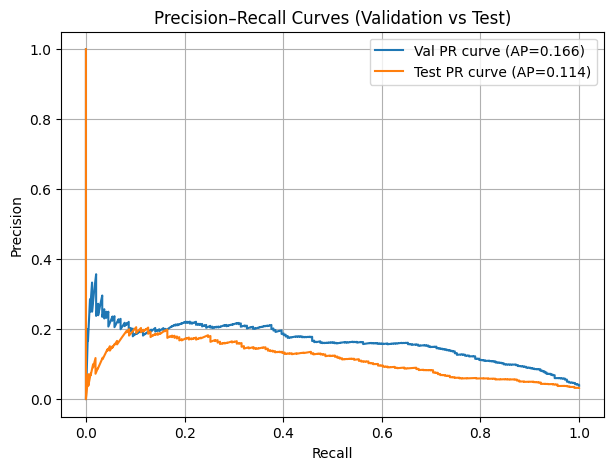

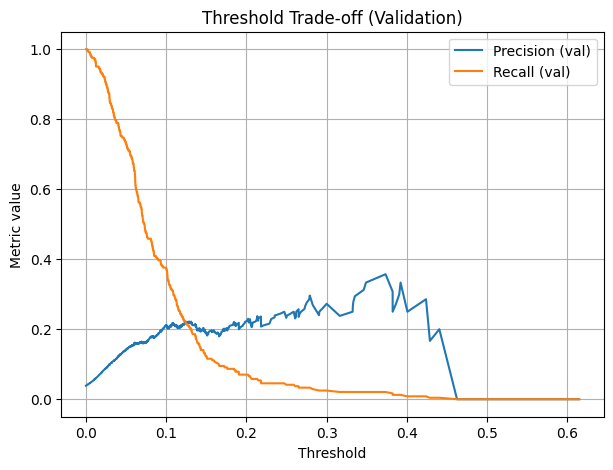

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_scores(pipe, X):
    """
    Return continuous scores for PR/AUC and thresholding.
    For models without predict_proba, we use decision_function.
    """
    model = pipe.named_steps["model"]
    if hasattr(model, "predict_proba"):
        return pipe.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        return pipe.decision_function(X)
    else:
        raise ValueError("Model has neither predict_proba nor decision_function.")

# Scores
val_scores  = get_scores(best_pipe, X_val)
test_scores = get_scores(best_pipe, X_test)

# PR curves
prec_v, rec_v, thr_v = precision_recall_curve(y_val, val_scores)
prec_t, rec_t, thr_t = precision_recall_curve(y_test, test_scores)

# PR-AUC (Average Precision)
ap_val  = average_precision_score(y_val, val_scores)
ap_test = average_precision_score(y_test, test_scores)

print(f"Best model: {best_name}")
print(f"Validation PR-AUC (AP): {ap_val:.4f}")
print(f"Test PR-AUC (AP):       {ap_test:.4f}")

# --- Plot PR curves ---
plt.figure(figsize=(7, 5))
plt.plot(rec_v, prec_v, label=f"Val PR curve (AP={ap_val:.3f})")
plt.plot(rec_t, prec_t, label=f"Test PR curve (AP={ap_test:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Validation vs Test)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot threshold vs precision/recall (validation) ---
# thr_v has length = len(prec_v)-1, so align arrays
plt.figure(figsize=(7, 5))
plt.plot(thr_v, prec_v[:-1], label="Precision (val)")
plt.plot(thr_v, rec_v[:-1], label="Recall (val)")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Threshold Trade-off (Validation)")
plt.legend()
plt.grid(True)
plt.show()

### How to read these plots

**PR curve:**
- Each point corresponds to a different threshold.
- Moving along the curve changes the balance:
  - **Higher recall** → you catch more true RI events, but usually with more false alarms (lower precision).
  - **Higher precision** → fewer false alarms, but you miss more RI events (lower recall).

**Threshold trade-off plot (validation):**
- As threshold increases, the model becomes “more strict” about predicting RI:
  - Precision usually goes **up**
  - Recall usually goes **down**

Because this is a rare-event detection problem, the PR curve is the most informative view of performance.

In [18]:
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def metrics_at_threshold(y_true, scores, thr):
    y_pred = (scores >= thr).astype(int)
    return {
        "threshold": thr,
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "cm": confusion_matrix(y_true, y_pred),
        "report": classification_report(y_true, y_pred, zero_division=0)
    }

# Candidate thresholds: use the validation PR curve thresholds
# (thr_v length matches prec_v[:-1] and rec_v[:-1])
f1_vals = 2 * (prec_v[:-1] * rec_v[:-1]) / (prec_v[:-1] + rec_v[:-1] + 1e-12)
best_idx = np.argmax(f1_vals)
best_thr = thr_v[best_idx]

print(f"Chosen threshold (max F1 on VAL): {best_thr:.6f}")
print(f"VAL @ threshold -> Precision={prec_v[:-1][best_idx]:.3f}, Recall={rec_v[:-1][best_idx]:.3f}, F1={f1_vals[best_idx]:.3f}")

# Evaluate on VAL and TEST using the chosen threshold
val_out  = metrics_at_threshold(y_val, val_scores, best_thr)
test_out = metrics_at_threshold(y_test, test_scores, best_thr)

print("\n--- TEST results at tuned threshold ---")
print(f"Precision: {test_out['precision']:.4f}")
print(f"Recall:    {test_out['recall']:.4f}")
print(f"F1:        {test_out['f1']:.4f}")
print("Confusion matrix:\n", test_out["cm"])
print("\nClassification report:\n", test_out["report"])

# OPTIONAL: also show a "high recall" and "high precision" threshold choice from VAL
# Example targets (adjust if you want):
target_recall = 0.80
target_precision = 0.20

# Find smallest threshold that achieves recall >= target_recall (validation)
idx_recall = np.where(rec_v[:-1] >= target_recall)[0]
if len(idx_recall) > 0:
    thr_high_recall = thr_v[idx_recall[-1]]  # more strict among those meeting recall
    print(f"\nAlt threshold for high recall (VAL recall >= {target_recall}): {thr_high_recall:.6f}")
else:
    thr_high_recall = None
    print(f"\nNo threshold achieves VAL recall >= {target_recall}")

# Find smallest threshold that achieves precision >= target_precision (validation)
idx_prec = np.where(prec_v[:-1] >= target_precision)[0]
if len(idx_prec) > 0:
    thr_high_prec = thr_v[idx_prec[0]]  # first point meeting precision target
    print(f"Alt threshold for higher precision (VAL precision >= {target_precision}): {thr_high_prec:.6f}")
else:
    thr_high_prec = None
    print(f"No threshold achieves VAL precision >= {target_precision}")

Chosen threshold (max F1 on VAL): 0.099913
VAL @ threshold -> Precision=0.212, Recall=0.376, F1=0.271

--- TEST results at tuned threshold ---
Precision: 0.1588
Recall:    0.2767
F1:        0.2018
Confusion matrix:
 [[5871  302]
 [ 149   57]]

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      6173
           1       0.16      0.28      0.20       206

    accuracy                           0.93      6379
   macro avg       0.57      0.61      0.58      6379
weighted avg       0.95      0.93      0.94      6379


Alt threshold for high recall (VAL recall >= 0.8): 0.036293
Alt threshold for higher precision (VAL precision >= 0.2): 0.095415


## Threshold tuning results (what changed and why it matters)

We **did not** change the model — we changed the *decision rule* used to convert scores into RI (0/1).

- The default threshold (often 0.5) is rarely optimal when positives are ~3%.
- By tuning on the **validation set**, we select an operating point aligned with our objective.
- We then report **test-set performance** at that tuned threshold to estimate real generalization.

**Interpretation:**
- If recall improves: we are catching more true RI events (better screening).
- If precision improves: we reduce false alarms (better operational usability).
- There is always a trade-off, which is exactly what the PR curve shows.

For hazard workflows, this tuned-threshold classifier can be used as a **triage tool**:
- rank storms by RI risk,
- flag top candidates for deeper physics-based analysis,
- allocate analyst attention more efficiently.

## Threshold Comparison Table (Validation → Test)

Because RI is a rare event, **the probability/score threshold controls the trade-off** between:

- **Recall** (catch more true RI events)
- **Precision** (reduce false alarms)

To make this decision explicit, we compare **multiple candidate thresholds**:

1. **Best-F1 (VAL)**: threshold that maximizes F1 on the validation set (balanced trade-off).
2. **High-Recall**: a lower threshold that targets a desired recall level (catch more RI).
3. **High-Precision**: a higher threshold that targets a desired precision level (fewer false alarms).

**How to read the table:**
- **VAL metrics** show how the threshold behaves on the validation split (used for choosing the threshold).
- **TEST metrics** show generalization on unseen storms (what we can expect in real use).
- **Confusion matrix (TEST)** summarizes outcomes:
  - TN = correct “No RI”
  - FP = false alarms
  - FN = missed RI
  - TP = correctly detected RI

This table supports an operational choice:
- If we want **high recall** → use the high-recall threshold.
- If we want **precision control** → use the high-precision threshold.
- If we want a **balanced screening rule** → use the best-F1 threshold.

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def metrics_at_threshold(y_true, scores, thr):
    y_pred = (scores >= thr).astype(int)
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "cm": confusion_matrix(y_true, y_pred)  # [[TN, FP],[FN, TP]]
    }

# --- thresholds we want to compare ---
thresholds = {
    "Best-F1 (VAL)": best_thr,          # from your earlier code
    "High-Recall (VAL)": thr_high_recall,
    "High-Precision (VAL)": thr_high_prec
}

rows = []
for name, thr in thresholds.items():
    if thr is None:
        continue

    val_out = metrics_at_threshold(y_val, val_scores, thr)
    test_out = metrics_at_threshold(y_test, test_scores, thr)
    tn, fp, fn, tp = test_out["cm"].ravel()

    rows.append({
        "choice": name,
        "threshold": float(thr),

        "VAL_precision": val_out["precision"],
        "VAL_recall": val_out["recall"],
        "VAL_f1": val_out["f1"],

        "TEST_precision": test_out["precision"],
        "TEST_recall": test_out["recall"],
        "TEST_f1": test_out["f1"],

        "TEST_TN": tn,
        "TEST_FP": fp,
        "TEST_FN": fn,
        "TEST_TP": tp,
        "TEST_alerts(TP+FP)": tp + fp
    })

comparison = pd.DataFrame(rows)

# Optional: nicer formatting
comparison = comparison.sort_values("TEST_f1", ascending=False)
display(comparison.style.format({
    "threshold": "{:.6f}",
    "VAL_precision": "{:.3f}",
    "VAL_recall": "{:.3f}",
    "VAL_f1": "{:.3f}",
    "TEST_precision": "{:.3f}",
    "TEST_recall": "{:.3f}",
    "TEST_f1": "{:.3f}",
}))

,choice,threshold,VAL_precision,VAL_recall,VAL_f1,TEST_precision,TEST_recall,TEST_f1,TEST_TN,TEST_FP,TEST_FN,TEST_TP,TEST_alerts(TP+FP)
2,High-Precision (VAL),0.095415,0.200,0.380,0.262,0.160,0.316,0.212,5832,341,141,65,406
0,Best-F1 (VAL),0.099913,0.212,0.376,0.271,0.159,0.277,0.202,5871,302,149,57,359
1,High-Recall (VAL),0.036293,0.112,0.802,0.197,0.083,0.694,0.148,4592,1581,63,143,1724


### Threshold Comparison (Validation → Test)

Because RI is rare (~3%), the decision threshold controls the **operational trade-off**:

- **Lower threshold** → higher **recall** (catch more RI) but many more **false alarms (FP)** → lower precision.
- **Higher threshold** → higher **precision** (fewer false alarms) but more **missed RI (FN)** → lower recall.

We compare three candidate thresholds:

1. **Best-F1 (VAL)**: maximizes F1 on validation (balanced screening rule).
2. **High-Recall (VAL)**: targets high recall (early-warning mode).
3. **High-Precision (VAL)**: targets higher precision (false-alarm control mode).

**How to read the table**
- **VAL metrics** show how the threshold behaved on the validation split (used for selection).
- **TEST metrics** show expected real-world generalization on unseen storms.
- **TEST confusion counts** translate performance into outcomes:
  - **TP** = detected RI events
  - **FN** = missed RI events
  - **FP** = false alarms
  - **TN** = correctly predicted “No RI”
  - **Alerts = TP + FP** = how many cases would be flagged for review.

**Interpretation of this run**
- The **high-recall** threshold catches most RI events, but produces many false alarms (high alert volume).
- The **best-F1 / higher-precision** thresholds reduce false alarms drastically, but miss more RI events.
- This supports choosing an operating point based on the mission goal: **early warning** vs **triage** vs **false-alarm control**.

## Operating Threshold (Locked)

We **lock the default operating threshold to Best-F1 (chosen on validation)** because it provides a **balanced screening rule** for a rare-event problem (RI ≈ 3%).
This threshold is the best “default mode” when we want a practical trade-off between **catching RI events (recall)** and **controlling false alarms (precision)**.

Operationally:
- Use **High-Recall** threshold when the mission priority is **early warning** (accept high alert volume).
- Use **High-Precision** threshold when the mission priority is **false-alarm control / triage efficiency**.

## Results Summary (Final)

### Best Model
- **LinearSVM** selected primarily by **Validation PR-AUC (Average Precision)**, with F1 as a secondary metric.

### Baseline (Default Decision Rule) — TEST
Using the model’s default decision rule (no threshold tuning):
- **Precision ≈ 0.08**, **Recall ≈ 0.70**, **F1 ≈ 0.14**
- Confusion matrix (TEST): **[[TN=4461, FP=1712], [FN=61, TP=145]]**
- Interpretation: the baseline setting catches many RI events (high recall) but produces **many false alarms**, which is costly in operations.

### Threshold Tuning (Validation → Test)
We tuned thresholds on **validation** and then evaluated them on **held-out test**. The comparison table shows the operational trade-offs:

- **High-Recall (~0.036)**: catches most RI events on test (**Recall ≈ 0.69**, TP=143) but produces **very high false alarms** (**FP=1581**).
- **Best-F1 (~0.100)**: balanced screening rule with much lower false alarms (**FP=302**) but lower recall (**Recall ≈ 0.28**, TP=57).
- **High-Precision (~0.095)**: best false-alarm control among the tuned options while keeping recall moderate (**FP=341**, **Recall ≈ 0.32**, TP=65).

**Conclusion:** threshold choice should match mission goal:
- early warning → high recall threshold
- triage / false-alarm control → higher threshold
- balanced screening default → Best-F1 threshold

### Generalization Note
Validation PR-AUC is higher than Test PR-AUC (**VAL AP ≈ 0.166 > TEST AP ≈ 0.114**), indicating an expected performance drop on unseen storms but consistent skill above rare-event baseline.